# 安徽安庆市项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Process Analysis`*

---
*@author: Evan*\
*@date: 2023-05-14*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
from findpoint import findpoint
import ModelEvaLib as me

## 读取数据

In [2]:
pa = xr.open_dataset('F:/Data/case_anqing/April/April_PA1.nc')

ncfile = pa.HADV_O3
HADV   = pa.HADV_O3
ZADV   = pa.ZADV_O3
HDIF   = pa.HDIF_O3
VDIF   = pa.VDIF_O3
DDEP   = pa.DDEP_O3
CHEM   = pa.CHEM_O3

In [3]:
siteloc = pd.read_excel('F:/Data/case_anqing/April/obsdata/安庆市站点坐标.xlsx',header=0,index_col=0)

sites = ['安庆大学','市人大','环科院','马山宾馆']

lono = siteloc[siteloc.index.isin(sites)]['经度']
lato = siteloc[siteloc.index.isin(sites)]['纬度']

print(lono,'\n',lato)

站点名称
安庆大学    116.9898
市人大     117.0597
环科院     117.0807
马山宾馆    117.0331
Name: 经度, dtype: float64 
 站点名称
安庆大学    30.6146
市人大     30.5351
环科院     30.5177
马山宾馆    30.5119
Name: 纬度, dtype: float64


In [4]:
x_index=[]
y_index=[]
for name in sites:
    out_x, out_y = findpoint(lono[name],lato[name],ncfile)
    x_index.append(out_x)
    y_index.append(out_y)

#! Loop start from here
i=3

HADV_sel = HADV.isel(x=x_index[i], y=y_index[i])
ZADV_sel = ZADV.isel(x=x_index[i], y=y_index[i])
HDIF_sel = HDIF.isel(x=x_index[i], y=y_index[i])
VDIF_sel = VDIF.isel(x=x_index[i], y=y_index[i])
CHEM_sel = CHEM.isel(x=x_index[i], y=y_index[i])
DDEP_sel = DDEP.isel(x=x_index[i], y=y_index[i])
HADV_sel.shape

(720, 38)

分别提取白天和夜晚数据后求平均，白天：6-18h

In [5]:
day_index=np.arange(6,18)
night_index=np.array([0,1,2,3,4,7,18,19,20,21,22,23])
days=[]
nights=[]
for i in range(30):
    days=np.append(days,day_index+24*i).astype(int)
    nights=np.append(nights,night_index+24*i).astype(int)

print(days.shape, nights.shape)

(360,) (360,)


In [6]:
%%time

nlevel   = 28
datadict = {}
outdict  = {}
vars     = ['HADV','ZADV','HDIF','VDIF','CHEM','DDEP']

for var in vars:
    for m in np.arange(1,4):
        var_day   = np.mean(np.array(locals()[f"{var}_sel"][days,:nlevel]).reshape(30,12,nlevel),1)
        var_night = np.mean(np.array(locals()[f"{var}_sel"][nights,:nlevel]).reshape(30,12,nlevel),1)
        
        datadict[f"{var}_m{m}_day"]   = np.mean(var_day[(m-1)*10:m*10,:],0)
        datadict[f"{var}_m{m}_night"] = np.mean(var_night[(m-1)*10:m*10,:],0)
        
        outdict[f"{var}_m{m}_dp"] = np.maximum(0,datadict[f"{var}_m{m}_day"])
        outdict[f"{var}_m{m}_dn"] = np.minimum(0,datadict[f"{var}_m{m}_day"])
        outdict[f"{var}_m{m}_np"] = np.maximum(0,datadict[f"{var}_m{m}_night"])
        outdict[f"{var}_m{m}_nn"] = np.minimum(0,datadict[f"{var}_m{m}_night"])

CPU times: total: 15min 8s
Wall time: 15min 18s


## 绘图

## 分时间段画图

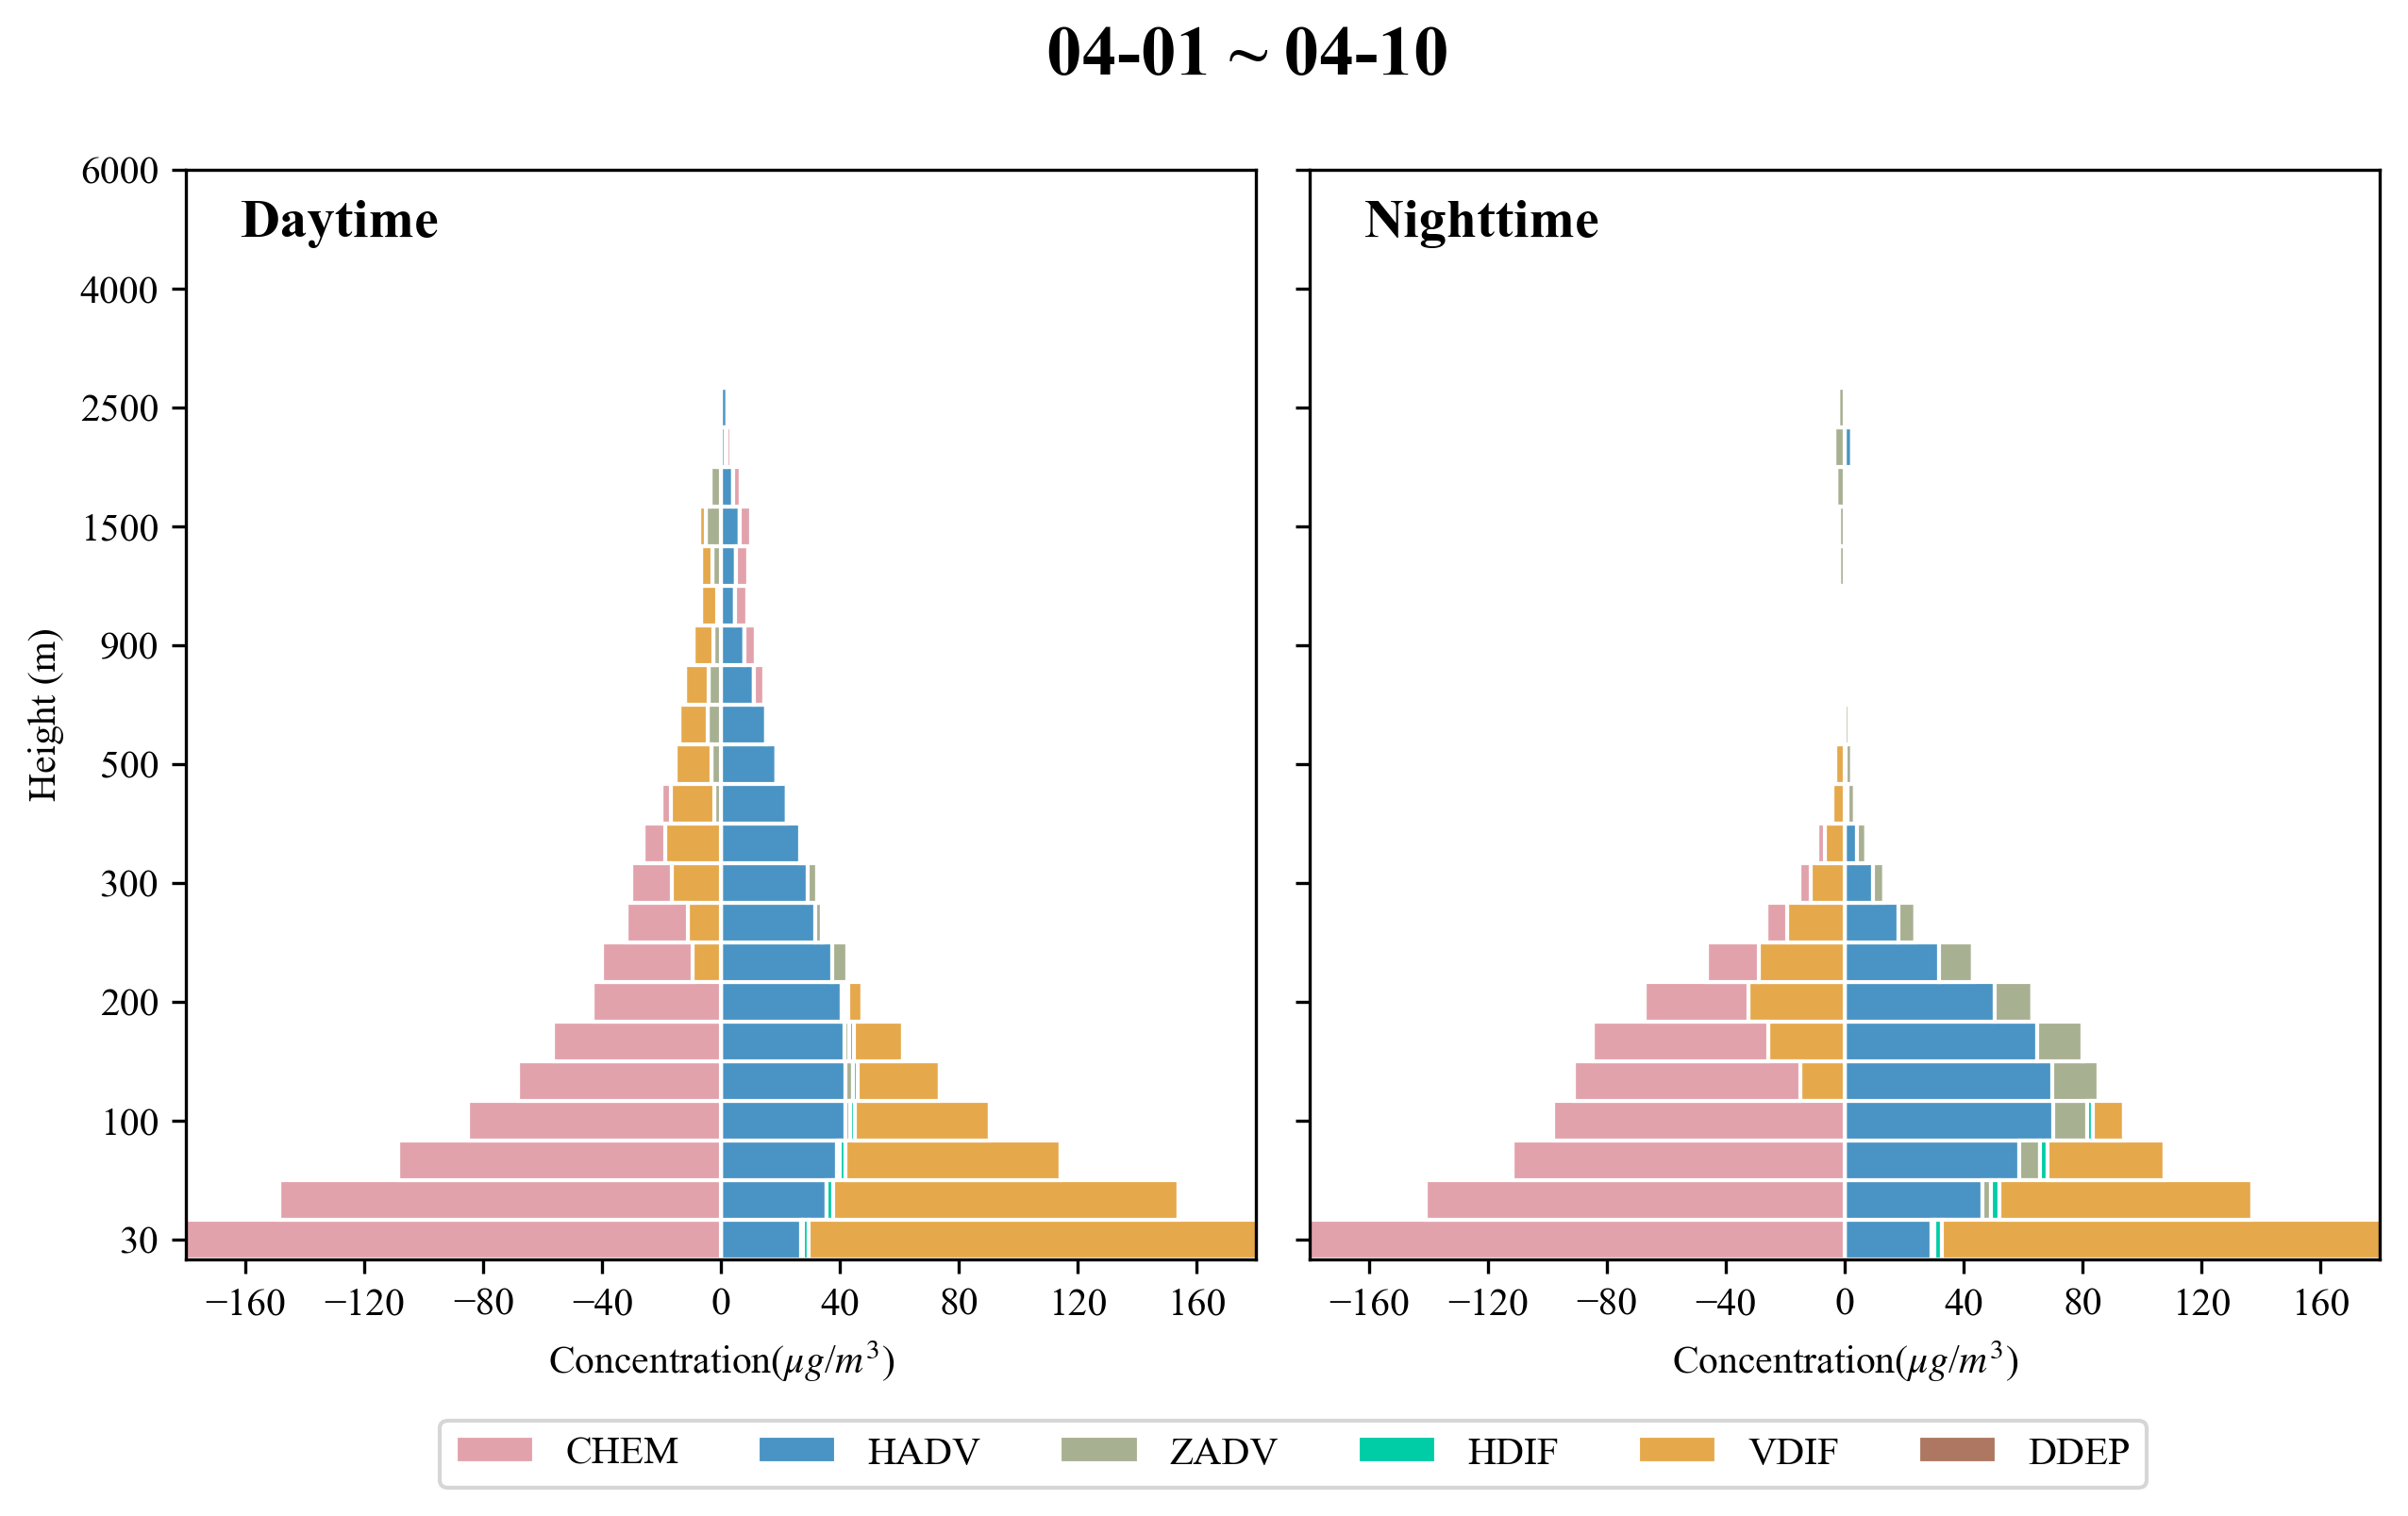

In [7]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_hdif = '#00cca6'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'
color_ddep = '#ad7761'

fig = plt.figure(figsize=(10,5),dpi=300)
ax  = fig.subplots(1,2,sharey=True,sharex=True)

b1=ax[0].barh(h,outdict['HADV_m1_dp'],color=color_hadv,height=1,edgecolor=edgec)
ax[0].barh(h,outdict['HADV_m1_dn'],color=color_hadv,height=1,edgecolor=edgec)

b2=ax[0].barh(h,outdict['ZADV_m1_dp'],color=color_zadv,left=outdict['HADV_m1_dp'],height=1,edgecolor=edgec)
ax[0].barh(h,outdict['ZADV_m1_dn'],color=color_zadv,left=outdict['HADV_m1_dn'],height=1,edgecolor=edgec)

b3=ax[0].barh(h,outdict['HDIF_m1_dp'],color=color_hdif,left=outdict['HADV_m1_dp']+outdict['ZADV_m1_dp'],height=1,edgecolor=edgec)
ax[0].barh(h,outdict['HDIF_m1_dn'],color=color_hdif,left=outdict['HADV_m1_dn']+outdict['ZADV_m1_dn'],height=1,edgecolor=edgec)

b4=ax[0].barh(h,outdict['VDIF_m1_dp'],color=color_vdif,left=outdict['HADV_m1_dp']+outdict['ZADV_m1_dp']+outdict['HDIF_m1_dp'],height=1,edgecolor=edgec)
ax[0].barh(h,outdict['VDIF_m1_dn'],color=color_vdif,left=outdict['HADV_m1_dn']+outdict['ZADV_m1_dn']+outdict['HDIF_m1_dn'],height=1,edgecolor=edgec)

b5=ax[0].barh(h,outdict['CHEM_m1_dp'],color=color_chem,left=outdict['HADV_m1_dp']+outdict['ZADV_m1_dp']+outdict['VDIF_m1_dp']+outdict['HDIF_m1_dp'],
            height=1,edgecolor=edgec)
ax[0].barh(h,outdict['CHEM_m1_dn'],color=color_chem,left=outdict['HADV_m1_dn']+outdict['ZADV_m1_dn']+outdict['VDIF_m1_dn']+outdict['HDIF_m1_dn'],
            height=1,edgecolor=edgec)

b6=ax[0].barh(h,outdict['DDEP_m1_dp'],color=color_ddep,left=outdict['HADV_m1_dp']+outdict['ZADV_m1_dp']+outdict['VDIF_m1_dp']+outdict['HDIF_m1_dp']+outdict['CHEM_m1_dp'],
            height=1,edgecolor=edgec)
ax[0].barh(h,outdict['DDEP_m1_dn'],color=color_ddep,left=outdict['HADV_m1_dn']+outdict['ZADV_m1_dn']+outdict['VDIF_m1_dn']+outdict['HDIF_m1_dn']+outdict['CHEM_m1_dn'],
            height=1,edgecolor=edgec)

# ax[0].set_xlim(-50,50)
ax[0].set_xlim(-180,180)
ax[0].set_ylim(-0.5,27)
ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
# ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_ylabel('Height (m)')
ax[0].set_xticks(np.arange(-160,161,40))
ax[0].set_yticks(np.arange(0,28,3))
ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
# ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

# ========================================================================================

b1=ax[1].barh(h,outdict['HADV_m1_np'],color=color_hadv,height=1,edgecolor=edgec)
ax[1].barh(h,outdict['HADV_m1_nn'],color=color_hadv,height=1,edgecolor=edgec)

b2=ax[1].barh(h,outdict['ZADV_m1_np'],color=color_zadv,left=outdict['HADV_m1_np'],height=1,edgecolor=edgec)
ax[1].barh(h,outdict['ZADV_m1_nn'],color=color_zadv,left=outdict['HADV_m1_nn'],height=1,edgecolor=edgec)

b3=ax[1].barh(h,outdict['HDIF_m1_np'],color=color_hdif,left=outdict['HADV_m1_np']+outdict['ZADV_m1_np'],height=1,edgecolor=edgec)
ax[1].barh(h,outdict['HDIF_m1_nn'],color=color_hdif,left=outdict['HADV_m1_nn']+outdict['ZADV_m1_nn'],height=1,edgecolor=edgec)

b4=ax[1].barh(h,outdict['VDIF_m1_np'],color=color_vdif,left=outdict['HADV_m1_np']+outdict['ZADV_m1_np']+outdict['HDIF_m1_np'],height=1,edgecolor=edgec)
ax[1].barh(h,outdict['VDIF_m1_nn'],color=color_vdif,left=outdict['HADV_m1_nn']+outdict['ZADV_m1_nn']+outdict['HDIF_m1_nn'],height=1,edgecolor=edgec)

b5=ax[1].barh(h,outdict['CHEM_m1_np'],color=color_chem,left=outdict['HADV_m1_np']+outdict['ZADV_m1_np']+outdict['VDIF_m1_np']+outdict['HDIF_m1_np'],
            height=1,edgecolor=edgec)
ax[1].barh(h,outdict['CHEM_m1_nn'],color=color_chem,left=outdict['HADV_m1_nn']+outdict['ZADV_m1_nn']+outdict['VDIF_m1_nn']+outdict['HDIF_m1_nn'],
            height=1,edgecolor=edgec)

b6=ax[1].barh(h,outdict['DDEP_m1_np'],color=color_ddep,left=outdict['HADV_m1_np']+outdict['ZADV_m1_np']+outdict['VDIF_m1_np']+outdict['HDIF_m1_np']+outdict['CHEM_m1_np'],
            height=1,edgecolor=edgec)
ax[1].barh(h,outdict['DDEP_m1_nn'],color=color_ddep,left=outdict['HADV_m1_nn']+outdict['ZADV_m1_nn']+outdict['VDIF_m1_nn']+outdict['HDIF_m1_nn']+outdict['CHEM_m1_nn'],
            height=1,edgecolor=edgec)

# ax[1].set_xlim(-50,50)
ax[1].set_xlim(-180,180)
ax[1].set_ylim(-0.5,27)
ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
ax[1].set_yticks(np.arange(0,28,3))
ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

ax[0].legend((b5,b1,b2,b3,b4,b6),('CHEM','HADV','ZADV','HDIF','VDIF','DDEP'),bbox_to_anchor=(1.85,-0.13),ncol=6)

plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.suptitle('04-01 ~ 04-10',
             fontsize=18,fontweight='bold')
plt.show()

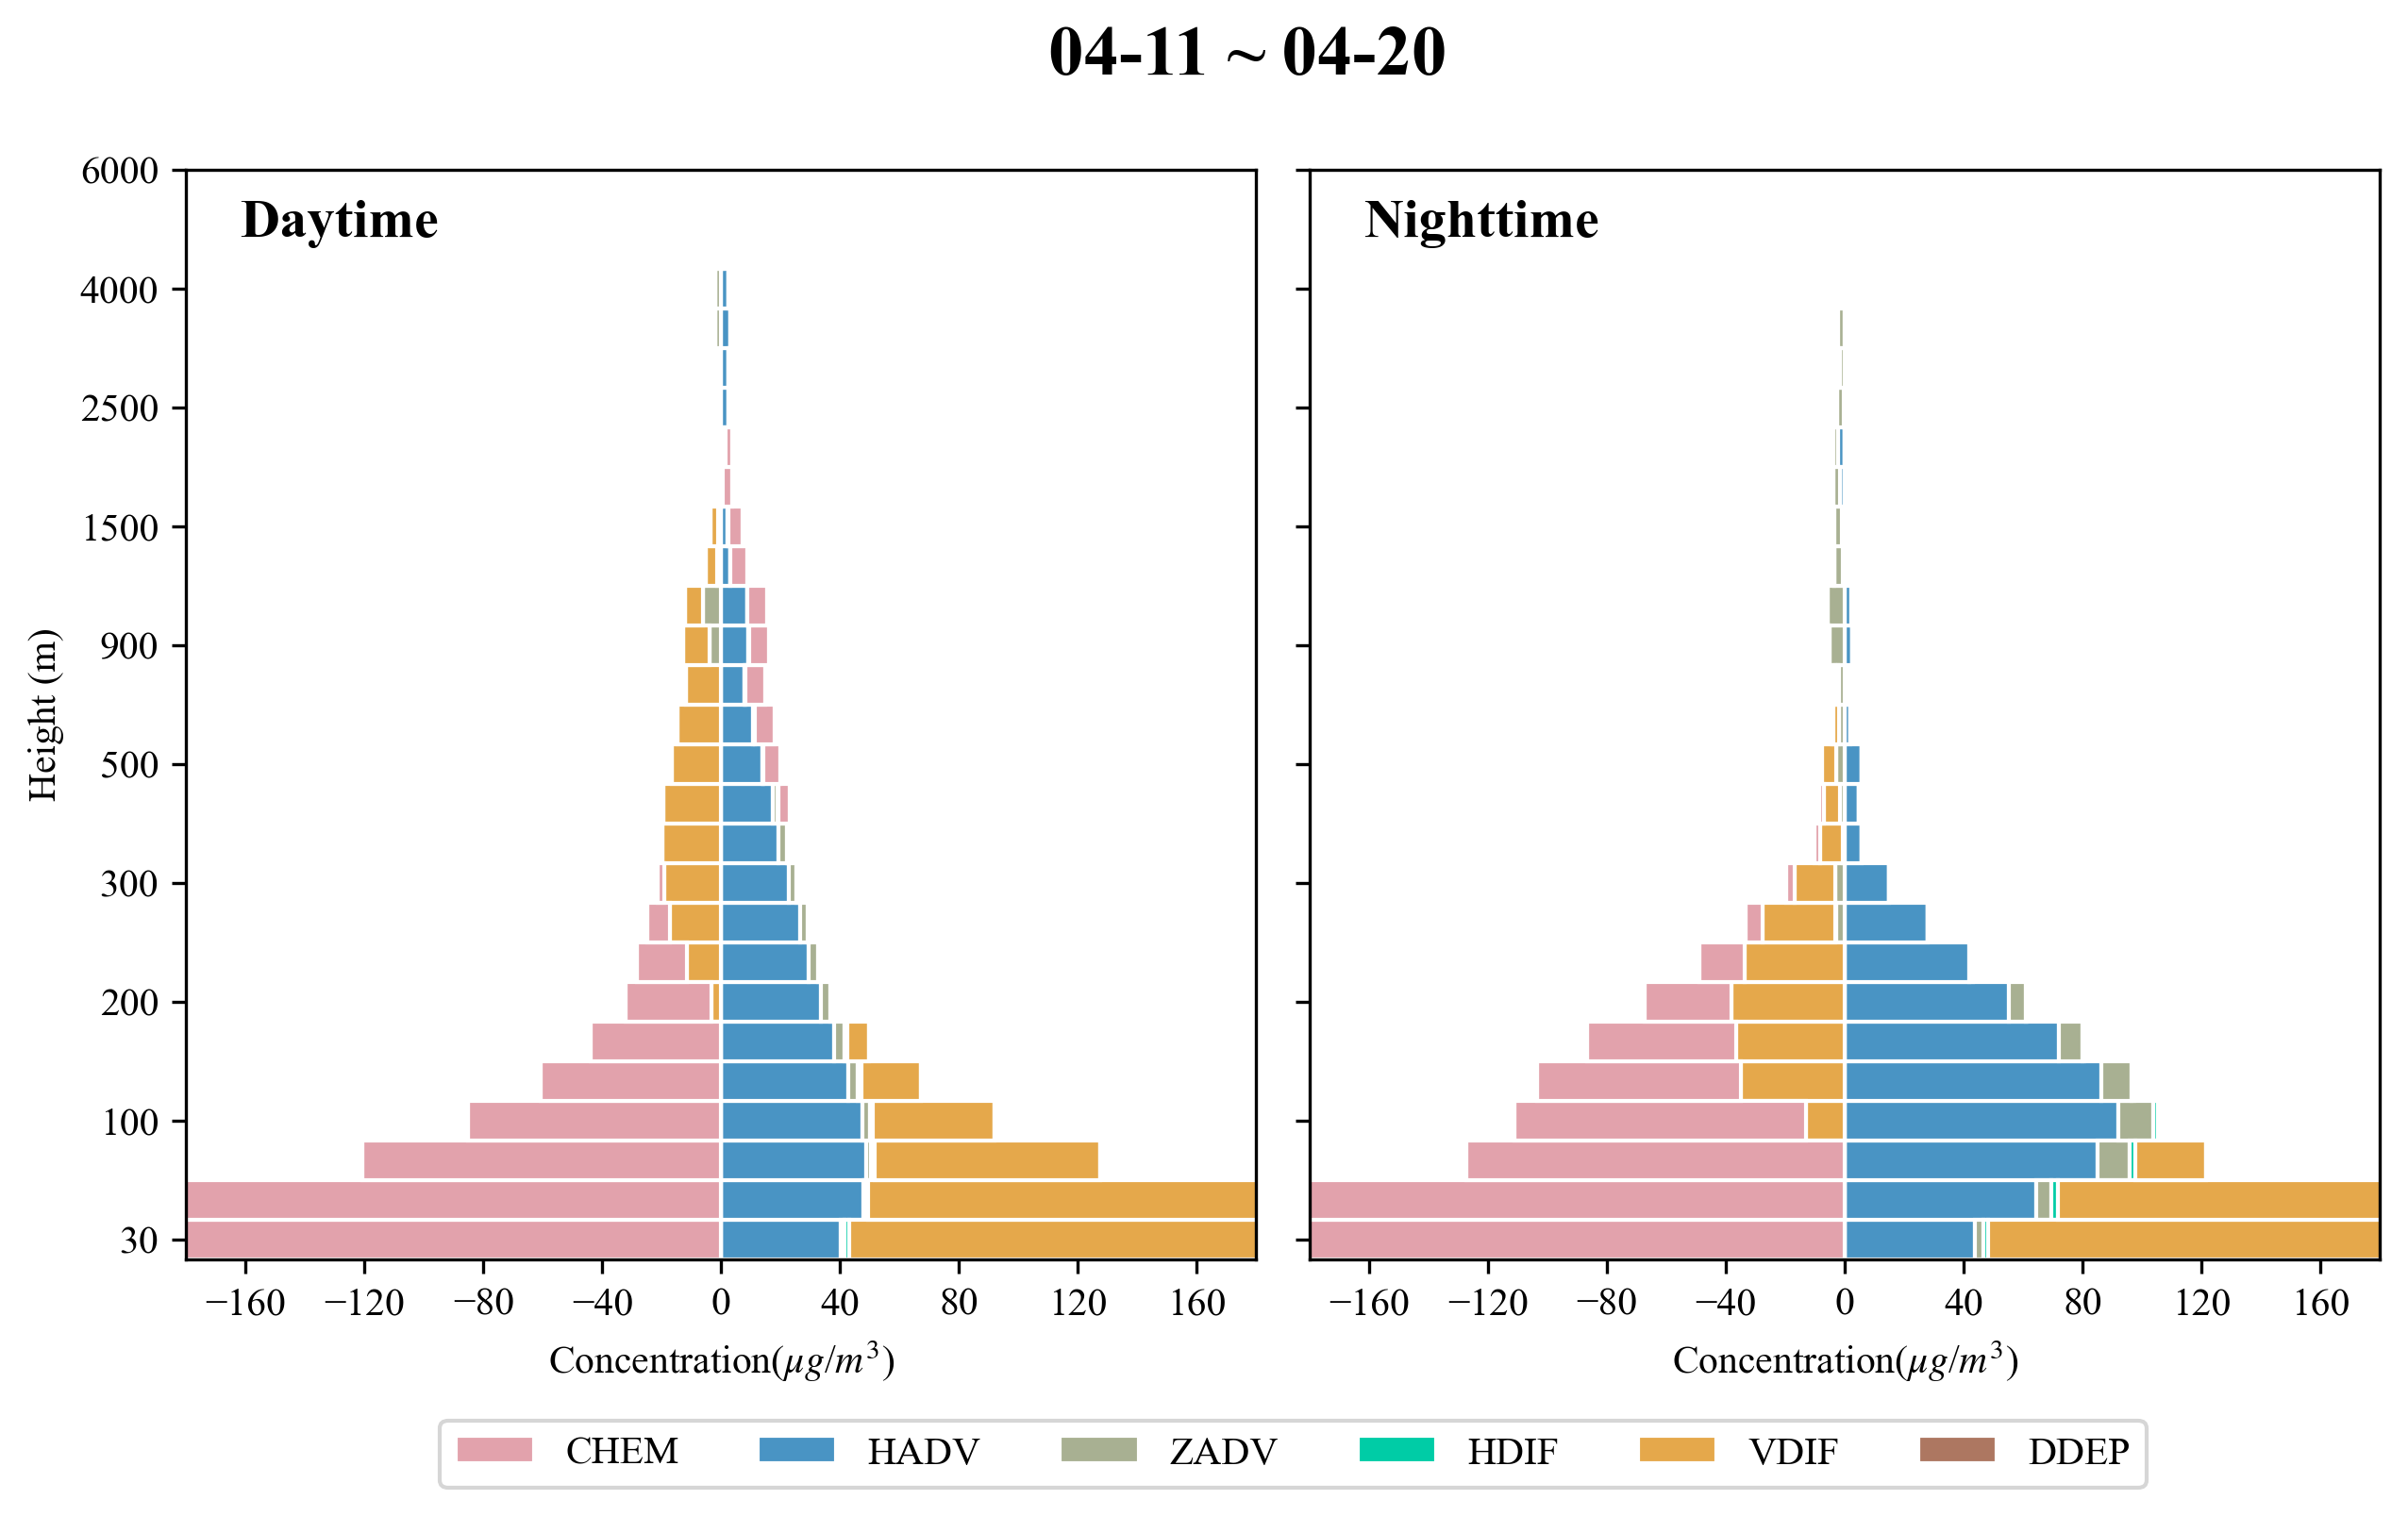

In [8]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_hdif = '#00cca6'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'
color_ddep = '#ad7761'

fig = plt.figure(figsize=(10,5),dpi=300)
ax  = fig.subplots(1,2,sharey=True,sharex=True)

b1=ax[0].barh(h,outdict['HADV_m2_dp'],color=color_hadv,height=1,edgecolor=edgec)
ax[0].barh(h,outdict['HADV_m2_dn'],color=color_hadv,height=1,edgecolor=edgec)

b2=ax[0].barh(h,outdict['ZADV_m2_dp'],color=color_zadv,left=outdict['HADV_m2_dp'],height=1,edgecolor=edgec)
ax[0].barh(h,outdict['ZADV_m2_dn'],color=color_zadv,left=outdict['HADV_m2_dn'],height=1,edgecolor=edgec)

b3=ax[0].barh(h,outdict['HDIF_m2_dp'],color=color_hdif,left=outdict['HADV_m2_dp']+outdict['ZADV_m2_dp'],height=1,edgecolor=edgec)
ax[0].barh(h,outdict['HDIF_m2_dn'],color=color_hdif,left=outdict['HADV_m2_dn']+outdict['ZADV_m2_dn'],height=1,edgecolor=edgec)

b4=ax[0].barh(h,outdict['VDIF_m2_dp'],color=color_vdif,left=outdict['HADV_m2_dp']+outdict['ZADV_m2_dp']+outdict['HDIF_m2_dp'],height=1,edgecolor=edgec)
ax[0].barh(h,outdict['VDIF_m2_dn'],color=color_vdif,left=outdict['HADV_m2_dn']+outdict['ZADV_m2_dn']+outdict['HDIF_m2_dn'],height=1,edgecolor=edgec)

b5=ax[0].barh(h,outdict['CHEM_m2_dp'],color=color_chem,left=outdict['HADV_m2_dp']+outdict['ZADV_m2_dp']+outdict['VDIF_m2_dp']+outdict['HDIF_m2_dp'],
            height=1,edgecolor=edgec)
ax[0].barh(h,outdict['CHEM_m2_dn'],color=color_chem,left=outdict['HADV_m2_dn']+outdict['ZADV_m2_dn']+outdict['VDIF_m2_dn']+outdict['HDIF_m2_dn'],
            height=1,edgecolor=edgec)

b6=ax[0].barh(h,outdict['DDEP_m2_dp'],color=color_ddep,left=outdict['HADV_m2_dp']+outdict['ZADV_m2_dp']+outdict['VDIF_m2_dp']+outdict['HDIF_m2_dp']+outdict['CHEM_m2_dp'],
            height=1,edgecolor=edgec)
ax[0].barh(h,outdict['DDEP_m2_dn'],color=color_ddep,left=outdict['HADV_m2_dn']+outdict['ZADV_m2_dn']+outdict['VDIF_m2_dn']+outdict['HDIF_m2_dn']+outdict['CHEM_m2_dn'],
            height=1,edgecolor=edgec)

# ax[0].set_xlim(-50,50)
ax[0].set_xlim(-180,180)
ax[0].set_ylim(-0.5,27)
ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
# ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_ylabel('Height (m)')
ax[0].set_xticks(np.arange(-160,161,40))
ax[0].set_yticks(np.arange(0,28,3))
ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
# ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

# ========================================================================================

b1=ax[1].barh(h,outdict['HADV_m2_np'],color=color_hadv,height=1,edgecolor=edgec)
ax[1].barh(h,outdict['HADV_m2_nn'],color=color_hadv,height=1,edgecolor=edgec)

b2=ax[1].barh(h,outdict['ZADV_m2_np'],color=color_zadv,left=outdict['HADV_m2_np'],height=1,edgecolor=edgec)
ax[1].barh(h,outdict['ZADV_m2_nn'],color=color_zadv,left=outdict['HADV_m2_nn'],height=1,edgecolor=edgec)

b3=ax[1].barh(h,outdict['HDIF_m2_np'],color=color_hdif,left=outdict['HADV_m2_np']+outdict['ZADV_m2_np'],height=1,edgecolor=edgec)
ax[1].barh(h,outdict['HDIF_m2_nn'],color=color_hdif,left=outdict['HADV_m2_nn']+outdict['ZADV_m2_nn'],height=1,edgecolor=edgec)

b4=ax[1].barh(h,outdict['VDIF_m2_np'],color=color_vdif,left=outdict['HADV_m2_np']+outdict['ZADV_m2_np']+outdict['HDIF_m2_np'],height=1,edgecolor=edgec)
ax[1].barh(h,outdict['VDIF_m2_nn'],color=color_vdif,left=outdict['HADV_m2_nn']+outdict['ZADV_m2_nn']+outdict['HDIF_m2_nn'],height=1,edgecolor=edgec)

b5=ax[1].barh(h,outdict['CHEM_m2_np'],color=color_chem,left=outdict['HADV_m2_np']+outdict['ZADV_m2_np']+outdict['VDIF_m2_np']+outdict['HDIF_m2_np'],
            height=1,edgecolor=edgec)
ax[1].barh(h,outdict['CHEM_m2_nn'],color=color_chem,left=outdict['HADV_m2_nn']+outdict['ZADV_m2_nn']+outdict['VDIF_m2_nn']+outdict['HDIF_m2_nn'],
            height=1,edgecolor=edgec)

b6=ax[1].barh(h,outdict['DDEP_m2_np'],color=color_ddep,left=outdict['HADV_m2_np']+outdict['ZADV_m2_np']+outdict['VDIF_m2_np']+outdict['HDIF_m2_np']+outdict['CHEM_m2_np'],
            height=1,edgecolor=edgec)
ax[1].barh(h,outdict['DDEP_m2_nn'],color=color_ddep,left=outdict['HADV_m2_nn']+outdict['ZADV_m2_nn']+outdict['VDIF_m2_nn']+outdict['HDIF_m2_nn']+outdict['CHEM_m2_nn'],
            height=1,edgecolor=edgec)

ax[1].set_xlim(-180,180)
ax[1].set_ylim(-0.5,27)
ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
ax[1].set_yticks(np.arange(0,28,3))
ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

ax[0].legend((b5,b1,b2,b3,b4,b6),('CHEM','HADV','ZADV','HDIF','VDIF','DDEP'),bbox_to_anchor=(1.85,-0.13),ncol=6)

plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.suptitle('04-11 ~ 04-20',
             fontsize=18,fontweight='bold')
plt.show()

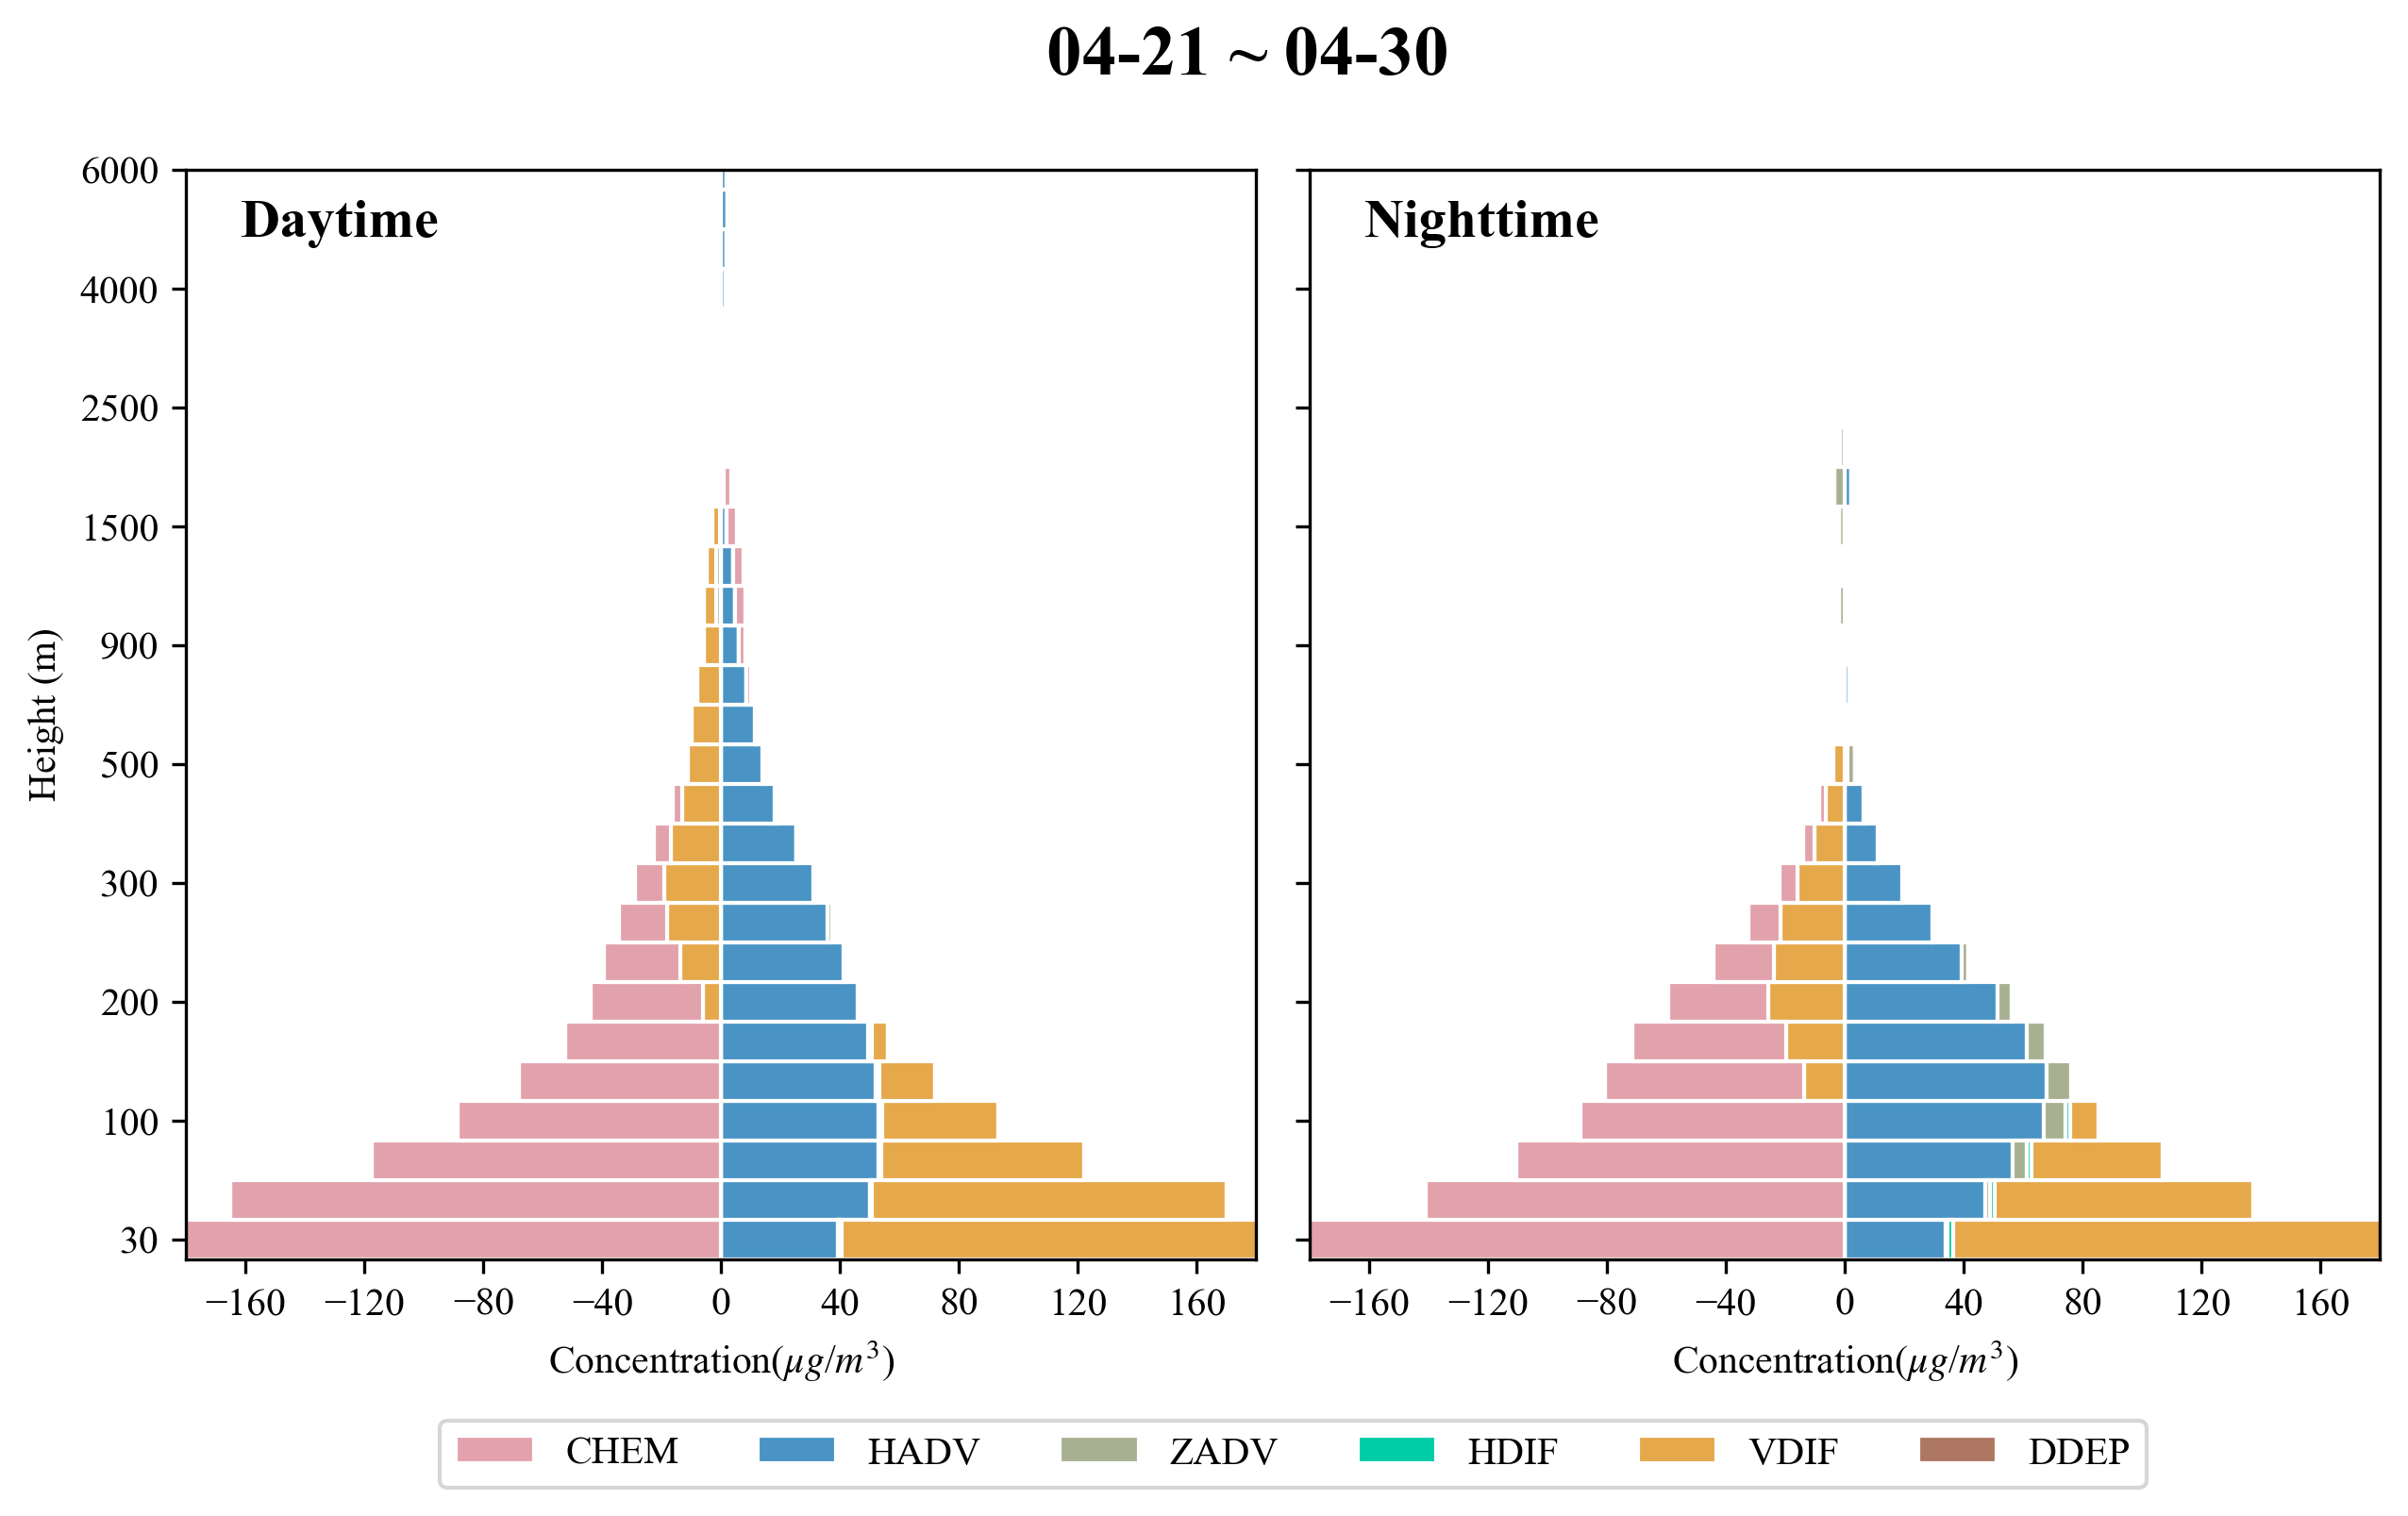

In [9]:
h   = np.arange(0,28)

edgec      = 'white'
color_hadv = '#4994c4'
color_zadv = '#a8b092'
color_hdif = '#00cca6'
color_vdif = '#e5a84b'
color_chem = '#e2a2ac'
color_ddep = '#ad7761'

fig = plt.figure(figsize=(10,5),dpi=300)
ax  = fig.subplots(1,2,sharey=True,sharex=True)

b1=ax[0].barh(h,outdict['HADV_m3_dp'],color=color_hadv,height=1,edgecolor=edgec)
ax[0].barh(h,outdict['HADV_m3_dn'],color=color_hadv,height=1,edgecolor=edgec)

b2=ax[0].barh(h,outdict['ZADV_m3_dp'],color=color_zadv,left=outdict['HADV_m3_dp'],height=1,edgecolor=edgec)
ax[0].barh(h,outdict['ZADV_m3_dn'],color=color_zadv,left=outdict['HADV_m3_dn'],height=1,edgecolor=edgec)

b3=ax[0].barh(h,outdict['HDIF_m3_dp'],color=color_hdif,left=outdict['HADV_m3_dp']+outdict['ZADV_m3_dp'],height=1,edgecolor=edgec)
ax[0].barh(h,outdict['HDIF_m3_dn'],color=color_hdif,left=outdict['HADV_m3_dn']+outdict['ZADV_m3_dn'],height=1,edgecolor=edgec)

b4=ax[0].barh(h,outdict['VDIF_m3_dp'],color=color_vdif,left=outdict['HADV_m3_dp']+outdict['ZADV_m3_dp']+outdict['HDIF_m3_dp'],height=1,edgecolor=edgec)
ax[0].barh(h,outdict['VDIF_m3_dn'],color=color_vdif,left=outdict['HADV_m3_dn']+outdict['ZADV_m3_dn']+outdict['HDIF_m3_dn'],height=1,edgecolor=edgec)

b5=ax[0].barh(h,outdict['CHEM_m3_dp'],color=color_chem,left=outdict['HADV_m3_dp']+outdict['ZADV_m3_dp']+outdict['VDIF_m3_dp']+outdict['HDIF_m3_dp'],
            height=1,edgecolor=edgec)
ax[0].barh(h,outdict['CHEM_m3_dn'],color=color_chem,left=outdict['HADV_m3_dn']+outdict['ZADV_m3_dn']+outdict['VDIF_m3_dn']+outdict['HDIF_m3_dn'],
            height=1,edgecolor=edgec)

b6=ax[0].barh(h,outdict['DDEP_m3_dp'],color=color_ddep,left=outdict['HADV_m3_dp']+outdict['ZADV_m3_dp']+outdict['VDIF_m3_dp']+outdict['HDIF_m3_dp']+outdict['CHEM_m3_dp'],
            height=1,edgecolor=edgec)
ax[0].barh(h,outdict['DDEP_m3_dn'],color=color_ddep,left=outdict['HADV_m3_dn']+outdict['ZADV_m3_dn']+outdict['VDIF_m3_dn']+outdict['HDIF_m3_dn']+outdict['CHEM_m3_dn'],
            height=1,edgecolor=edgec)

ax[0].set_xlim(-180,180)
ax[0].set_ylim(-0.5,27)
ax[0].set_xlabel('Concentration($\mu$$g$/$m^3$)')
# ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_ylabel('Height (m)')
ax[0].set_xticks(np.arange(-160,161,40))
ax[0].set_yticks(np.arange(0,28,3))
ax[0].set_yticklabels(['30','100','200','300','500','900','1500','2500','4000','6000'])
# ax[0].set_yticklabels(['1000','993','985','972','950','916','850','770','660','520'])
ax[0].text(0.05,0.95,'Daytime',va='center',transform=ax[0].transAxes,size=14,fontweight='bold')

# ========================================================================================

b1=ax[1].barh(h,outdict['HADV_m3_np'],color=color_hadv,height=1,edgecolor=edgec)
ax[1].barh(h,outdict['HADV_m3_nn'],color=color_hadv,height=1,edgecolor=edgec)

b2=ax[1].barh(h,outdict['ZADV_m3_np'],color=color_zadv,left=outdict['HADV_m3_np'],height=1,edgecolor=edgec)
ax[1].barh(h,outdict['ZADV_m3_nn'],color=color_zadv,left=outdict['HADV_m3_nn'],height=1,edgecolor=edgec)

b3=ax[1].barh(h,outdict['HDIF_m3_np'],color=color_hdif,left=outdict['HADV_m3_np']+outdict['ZADV_m3_np'],height=1,edgecolor=edgec)
ax[1].barh(h,outdict['HDIF_m3_nn'],color=color_hdif,left=outdict['HADV_m3_nn']+outdict['ZADV_m3_nn'],height=1,edgecolor=edgec)

b4=ax[1].barh(h,outdict['VDIF_m3_np'],color=color_vdif,left=outdict['HADV_m3_np']+outdict['ZADV_m3_np']+outdict['HDIF_m3_np'],height=1,edgecolor=edgec)
ax[1].barh(h,outdict['VDIF_m3_nn'],color=color_vdif,left=outdict['HADV_m3_nn']+outdict['ZADV_m3_nn']+outdict['HDIF_m3_nn'],height=1,edgecolor=edgec)

b5=ax[1].barh(h,outdict['CHEM_m3_np'],color=color_chem,left=outdict['HADV_m3_np']+outdict['ZADV_m3_np']+outdict['VDIF_m3_np']+outdict['HDIF_m3_np'],
            height=1,edgecolor=edgec)
ax[1].barh(h,outdict['CHEM_m3_nn'],color=color_chem,left=outdict['HADV_m3_nn']+outdict['ZADV_m3_nn']+outdict['VDIF_m3_nn']+outdict['HDIF_m3_nn'],
            height=1,edgecolor=edgec)

b6=ax[1].barh(h,outdict['DDEP_m3_np'],color=color_ddep,left=outdict['HADV_m3_np']+outdict['ZADV_m3_np']+outdict['VDIF_m3_np']+outdict['HDIF_m3_np']+outdict['CHEM_m3_np'],
            height=1,edgecolor=edgec)
ax[1].barh(h,outdict['DDEP_m3_nn'],color=color_ddep,left=outdict['HADV_m3_nn']+outdict['ZADV_m3_nn']+outdict['VDIF_m3_nn']+outdict['HDIF_m3_nn']+outdict['CHEM_m3_nn'],
            height=1,edgecolor=edgec)

ax[1].set_xlim(-180,180)
ax[1].set_ylim(-0.5,27)
ax[1].set_xlabel('Concentration($\mu$$g$/$m^3$)')
ax[1].set_yticks(np.arange(0,28,3))
ax[1].text(0.05,0.95,'Nighttime',va='center',transform=ax[1].transAxes,size=14,fontweight='bold')

ax[0].legend((b5,b1,b2,b3,b4,b6),('CHEM','HADV','ZADV','HDIF','VDIF','DDEP'),bbox_to_anchor=(1.85,-0.13),ncol=6)

plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.suptitle('04-21 ~ 04-30',
             fontsize=18,fontweight='bold')
plt.show()